# Aim

scaling music GPT with larger number of parameters with better performance on the valid loss on data-constrained setting.

The music datasets are limited (33.6B abc notations at most), which may lead to significantly overfitting for too many epochs for a LLM.

# Related-work

A wide range of research underscores a significant pattern in language model performance, indicating a power-law relationship between model performance and the increases in both the number of parameters and the size of the training data [1]. Scaling law plays a pivotal role in advancing large language models (LLMs), offering a framework to predict the optimal configurations for larger models based on the training logs of their smaller counterparts.


Further exploration into scaling laws for autoregressive generative modeling broadens the applicability of these laws to include not just textual, but also visual and multimodal tasks, as supported by studies in [2-4]. Such insights are invaluable for developing music generation models, which often blend multiple modalities such as music score, audio, lyrics, and visual elements like album covers or artist photos. This demonstrates a consistent trajectory of performance enhancement concurrent with resource scaling.

Recent investigations, notably by researchers identified in [1], advocate for a balanced approach to scaling both model size and training data. This perspective underscores the necessity of enlarging pre-training datasets to advance model capabilities. The challenge becomes particularly pronounced in the context of musical pre-training, where datasets are often notably smaller, thus constraining potential improvements in model performance. While up-sampling represents a potential strategy for mitigating data limitations, the study by [5] illustrates its pitfalls; specifically, they discovered that amplifying just 0.1% of the training dataset by a factor of 100 led to a marked decline in model efficacy. 
The research by [6], which involves the repetition of the entire pre-training dataset across multiple epochs, presents promising results yet raises questions regarding its effectiveness for musical data. This uncertainty prompts a need for further research into the impact of data repetition strategy by achieving improved outcomes for models engaged in music-related tasks.


[1] Hoffmann J, Borgeaud S, Mensch A, et al. Training compute-optimal large language models[J]. arXiv preprint arXiv:2203.15556, 2022.

[2] Ghorbani B, Firat O, Freitag M, et al. Scaling laws for neural machine translation[J]. arXiv preprint arXiv:2109.07740, 2021.

[3] Hernandez D, Kaplan J, Henighan T, et al. Scaling laws for transfer[J]. arXiv preprint arXiv:2102.01293, 2021.

[4] Gao L, Schulman J, Hilton J. Scaling laws for reward model overoptimization[C]//International Conference on Machine Learning. PMLR, 2023: 10835-10866.

[5] Hernandez D, Brown T, Conerly T, et al. Scaling laws and interpretability of learning from repeated data[J]. arXiv preprint arXiv:2205.10487, 2022.

[6] Muennighoff N, Rush A, Barak B, et al. Scaling data-constrained language models[J]. Advances in Neural Information Processing Systems, 2024, 36.

# Methods of baseline scaling law:
In this research, we used the Chinchilla Law [1] and Data-Constrained law [6] as baselines. The former is a classical baseline in LLMs' training. It is proposed by DeepMind, is a scaling law that provides insights into the training of large language models (LLMs). Our experiments reveal that the Chinchilla Law \citep{hoffmann2022training} provides a good fit for general cases, where moderate models were trained with a moderate amount of data.
And the latter is crucial to address the constraints faced in scenarios where the volume of available training data does not meet the ideal requisites. This phenomenon is typical in the music domain.

In [6]:
# loading datas from MuPT training logs
import pandas as pd


tmp = " MegatronLM"

data_16 = pd.read_excel(
    f"/Users/nicolaus625/Downloads/MuPT valid loss{tmp}.xlsx", sheet_name=0)
data_4 = pd.read_excel(
    f"/Users/nicolaus625/Downloads/MuPT valid loss{tmp}.xlsx", sheet_name=1)
data_all = pd.read_excel(
    f"/Users/nicolaus625/Downloads/MuPT valid loss{tmp}.xlsx", sheet_name=2)


maps = {
    "190M":190065408,
    "505M":505103360,
    "1.072B":1071811840,
    "2.1B":1965688320,
    "4.2B":4231827456,
}


def extract_details_from_dataframe(df, ut):
    # Initialize empty lists to hold the entries, column headers, and row indices
    entries, columns, rows, uts = [], [], [], []

    df = df.set_index(df.columns[0])

    # Iterate over each cell in the DataFrame
    for row_index, row in df.iterrows():
        for col_name, value in row.items():
            # Append the value to the entries list
            if not pd.isnull(value):
                entries.append(value)
                columns.append(int(col_name)*1024*8192*1e-9)
                rows.append(maps[row_index])
                uts.append(ut)

    return entries, columns, rows, uts

model_params, tokens, unique_tokens, losses = [], [], [], []
entries, columns, rows, uts = extract_details_from_dataframe(
    data_4, ut=33.6e9/4*1e-9)
model_params += rows
tokens += columns
unique_tokens += uts
losses += entries
entries, columns, rows, uts = extract_details_from_dataframe(
    data_16, ut=33.6e9/16*1e-9)
model_params += rows
tokens += columns
unique_tokens += uts
losses += entries
entries, columns, rows, uts = extract_details_from_dataframe(
    data_all, ut=33.6e9*1e-9)
model_params += rows
tokens += columns
unique_tokens += uts
losses += entries

# If you need to inspect the results
print("Rows:", model_params)
print("Columns:", tokens)
print("Entries:", losses)

indices = [i for i, x in enumerate(model_params) if x <1.5e9]
train_model_params = [model_params[i] for i in indices]
train_tokens = [tokens[i] for i in indices]
train_losses = [losses[i] for i in indices]
train_unique_tokens = [unique_tokens[i] for i in indices]

indices = [i for i, x in enumerate(model_params) if x >1.5e9]
test_model_params = [model_params[i] for i in indices]
test_tokens = [tokens[i] for i in indices]
test_losses = [losses[i] for i in indices]
test_unique_tokens = [unique_tokens[i] for i in indices]

print(len(train_losses), len(losses))


Rows: [190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 505103360, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 1071811840, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 190065408, 1900654

## Evaluation Metrics \& Fitting Methodology
We use the $R^2$ value and Huber loss (with the parameter $\delta=1e-3$) between the authentic valid loss and predicted valid loss on small models (190M, 505M, 1.07B) to acquire the best scaling law. Then we use the best law to train two large models (with 1.97B and 4.23B).

For more information about the two evaluation methods, please refer to Appendix \ref{evlauation}.
We optimized the SMS Law using the L-BFGS algorithm, the same with Chinchilla and Data-Constrained Laws. 

## Chinchilla Law
In this part, we focus on the relationship of loss metrics to various resource budgets in deep learning. It is first put forward by the Chinchilla Law as illustrated in the follow Equation. This law posits that both training and evaluation losses can be abstracted as a function of model capacity $N$ and training data size $D$, thus offering an insight to estimate the best combination of resources to be assigned to training.

\begin{equation}
L(N, D) = \frac{A}{N^\alpha} + \frac{B}{D^\beta} + E
\label{Chinchilla}
\end{equation}

Here, $L(N,D)$ denotes the loss metric during training or evaluation, which is assumed to exhibit a power-law dependency on $N$ and $D$. The parameters $A$, $B$, $E$, $\alpha$, and $\beta$ are determined by empirical fitting.

A pivotal aspect of scaling laws is the optimization of loss within the bounds of computational feasibility. This is formalized as minimizing the valid loss $L$, subject to constraints imposed by available computational resources ($C$), specifically FLOPs, as denoted below:

\begin{equation}
\arg\min_{N,D} L(N, D) \quad \text{s.t.} \quad \text{FLOPs}(N, D) = C
\end{equation}


This framework encapsulates the trade-offs between parameters ($N$) and training tokens ($D$), and decision-making processes inherent in scaling models under resource limitations, illuminating pathways to efficiency and efficacy in LLMs training. 

In [7]:
# Fit with Chinchila law
### Adapted from https://github.com/bigcode-project/bigcode-analysis/blob/91daccbc13cd972b7ce9627e6e1890c9affbf3cc/data_analysis/notebooks/ScalingLaws.ipynb ###
import torch
import numpy as np

def loss(inp, params, tie):
    if tie:
        a, b, e, alpha, beta = params[0], params[1], params[2], params[3], params[3]
    else:
        a, b, e, alpha, beta = params[0], params[1], params[2], params[3], params[4]

    pre_lse = torch.stack([
        a - alpha*torch.log(inp[:, 0]), 
        b - beta*torch.log(inp[:, 1]), 
        e.expand((inp.shape[0]))
    ])
    post_lse = torch.logsumexp(pre_lse, dim=0)
    huber_loss = torch.nn.functional.huber_loss(post_lse, torch.log(inp[:, -1]), delta=1e-3, reduction='none')
    return huber_loss.sum()

def minimize_loss(inp, init_params=[6, 6, -1, 0.28, 0.28], steps=50, fixed=False, fix_e=False, tie=False):
    params = torch.nn.Parameter(data=torch.Tensor(init_params))
    if tie:
        params = torch.nn.Parameter(data=torch.Tensor(init_params[:-1]))

    lbfgs = torch.optim.LBFGS([params],
                    lr=1e-1,
                    history_size=10,
                    max_iter=20,
                    line_search_fn="strong_wolfe")

    def closure():
        lbfgs.zero_grad()
        l = loss(inp, params, tie=tie)

        l.backward()
        if fixed:
            # Do not backprop on fixed params
            # https://discuss.pytorch.org/t/set-a-portion-of-a-tensor-to-have-requires-grad-false/157856
            params.grad[:3] = 0
        elif fix_e:
            params.grad[2] = 0
        return l

    history_lbfgs = []
    for i in range(steps):
        l = lbfgs.step(closure)
    return l, params

### FIT CHINCHILLA C4 ISOFLOP DOTS ###

from tqdm import tqdm
import math

inp = torch.Tensor([
    [p, t, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(train_model_params, train_tokens, train_unique_tokens, train_losses)
])
inp.require_grad = True
min_loss = 1e10

for a in tqdm(np.linspace(0, 12, 4)):
    for b in np.linspace(0, 12, 4):
        for e in np.linspace(-1, 1, 4):
            for alpha in np.linspace(0, 1, 4):
                for beta in np.linspace(0, 1, 4):
                    l, params = minimize_loss(inp, [a, b, e, alpha, beta], tie=False)
                    if l < min_loss:
                        min_loss = l
                        best_params = params.detach().numpy()
                        print("Current loss & params: ", min_loss, list(best_params))


print("Samples: ", len(inp))
print("Min Loss: ", float(min_loss))
print("a, b, e, alpha, beta: ", best_params)


  0%|          | 0/4 [00:00<?, ?it/s]

Current loss & params:  tensor(0.0109, grad_fn=<SumBackward0>) [2.0964184, 2.7920732, -2.5476208, 0.15269276, 1.1644834]
Current loss & params:  tensor(0.0109, grad_fn=<SumBackward0>) [6.930559, 2.797794, -1.0698674, 0.45363402, 1.1681643]
Current loss & params:  tensor(0.0109, grad_fn=<SumBackward0>) [7.003183, 2.798342, -1.0652758, 0.45787653, 1.1685705]


100%|██████████| 4/4 [02:28<00:00, 37.08s/it]

Samples:  179
Min Loss:  0.010890167206525803
a, b, e, alpha, beta:  [ 7.003183    2.798342   -1.0652758   0.45787653  1.1685705 ]


In [8]:
# r2_score of chinchilla_law
from sklearn.metrics import r2_score


# best_params =  [7.003183, 2.798342, -1.0652758, 0.45787653, 1.1685705]
# [12.018001,  3.178623,-0.91808516,0.73794556, 1.2687991 ]

def chinchilla_law(N, D, params):
    a, b, e, alpha = params[:4]
    beta = params[-1]
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    L = E + A/(N)**alpha + B / D**beta
    return L

a, b, e, alpha = best_params[:4]
beta = best_params[-1]
A = np.exp(a)
B = np.exp(b)
E = np.exp(e)
G = ((alpha*A)/(beta*B))**(1/(alpha+beta))
def optimal_N(C):
    a = (beta)/(alpha+beta)
    N_opt = G*(C/6)**a
    return N_opt
def D_to_C(D):
    b = (alpha)/(alpha+beta)
    C = ((G*D) ** (1/b)) * 6
    return C

inp = torch.Tensor([
    [p, t, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(test_model_params, test_tokens, test_unique_tokens, test_losses)
])
ls = chinchilla_law(inp[:,0], inp[:,1], best_params)
print("test r2_score:", r2_score(inp[:,-1], ls))
test_l = torch.nn.functional.huber_loss(torch.log(ls), torch.log(inp[:, -1]), delta=1e-3, reduction='none').sum()
print("test loss:", float(test_l))

inp = torch.Tensor([
    [p, t, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(train_model_params, train_tokens, train_unique_tokens, train_losses)
])
ls = chinchilla_law(inp[:,0], inp[:,1], best_params)
print("train r2_score:", r2_score(inp[:,-1], ls))
test_l = torch.nn.functional.huber_loss(torch.log(ls), torch.log(inp[:, -1]), delta=1e-3, reduction='none').sum()
print("train loss:", float(test_l))

inp = torch.Tensor([
    [p, t, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(model_params, tokens, unique_tokens, losses)
])
ls = chinchilla_law(inp[:,0], inp[:,1], best_params)
print("r2_score:", r2_score(inp[:,-1], ls))


/Users/nicolaus625/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


test r2_score: -0.09334700940302709
test loss: 0.008037213236093521
train r2_score: 0.9346608918473381
train loss: 0.010890168137848377
r2_score: 0.8955258644528553


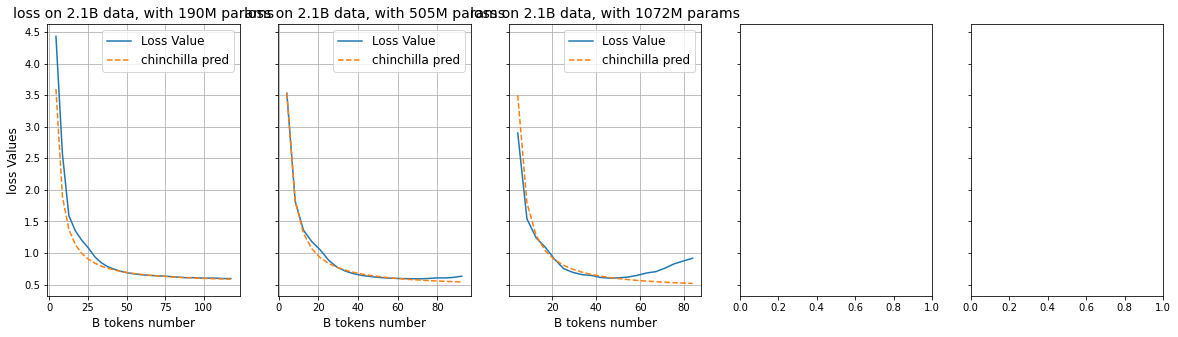

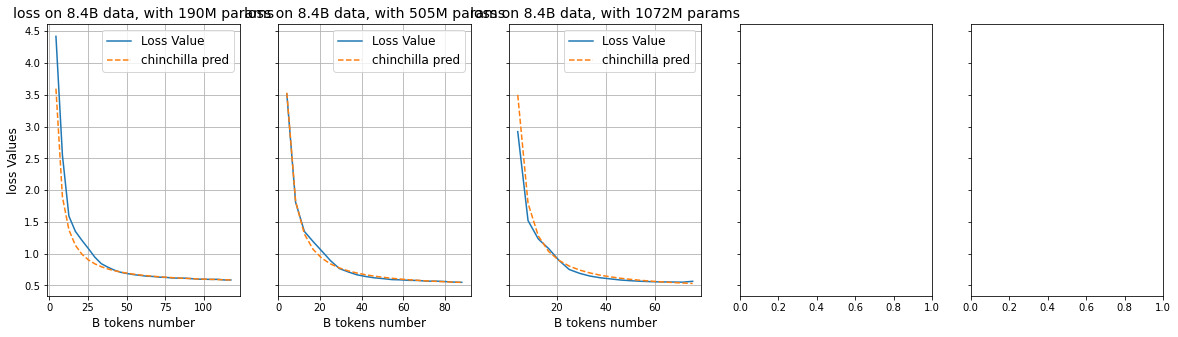

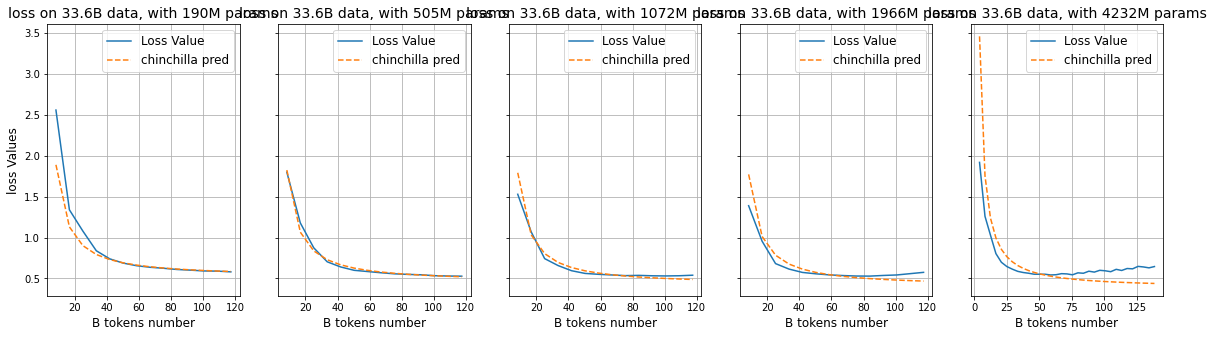

In [9]:
import matplotlib.pyplot as plt

def plot_figures(rows, columns, entries, unique_tokens, ut):
    indices = [i for i, x in enumerate(unique_tokens) if x == ut]
    rows = [rows[i] for i in indices]
    columns = [columns[i] for i in indices]
    entries = [entries[i] for i in indices]
    
    unique_rows = set(rows)
    unique_rows = sorted(unique_rows)
    fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

    for j, row in enumerate(unique_rows):
        indices = [i for i, x in enumerate(rows) if x == row]
        x_vals = [columns[i] for i in indices]
        y_vals = [entries[i] for i in indices]
        f_vals = [chinchilla_law(row,x,best_params) for x in x_vals]

        axs[j].plot(x_vals, y_vals, label='Loss Value')
        axs[j].plot(x_vals, f_vals, label='chinchilla pred', linestyle='--')
        axs[j].set_title(f"loss on {ut/1e9*1e9:.1f}B data, with {row*1e-6:.0f}M params", fontsize=14)
        axs[j].set_xlabel('B tokens number', fontsize=12)
        axs[j].grid(True)
        if j == 0:
            axs[j].set_ylabel('loss Values', fontsize=12)
        axs[j].legend(fontsize=12)

# Plot the figures
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/16)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/4)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6)


## Data-constrained Law
Complementing the Chinchilla Law, the Data-Constrained Law shows the scaling dynamics of LLMs when facing the data scarcity problem. Here, we strictly refer to the derivation method of [6].
The goal of discovering Data-Constrained Scaling Law is to generalize the expression to multiple epochs where tokens are repeated. 

Data-constrained law is defined as:
\begin{equation} \label{data-constrain}
     L\left(N, D, U_D\right)=\frac{A}{N'^\alpha} + \frac{B}{D'^\beta} +E
\end{equation}
where
\begin{equation}\label{eq-D'}
\begin{split}
 & N' = U_N + U_NR_N^\star\left(1-\exp\left(\frac{-R_N}{R_N^\star}\right)\right)\\
 & D' = U_D + U_DR_D^\star\left(1-\exp\left(\frac{-R_D}{R_D^\star}\right)\right)\\
\end{split}
\end{equation}
To get a better understanding of the equation, the definitions of each of the above parameters are as follows:

$ N $ is defined as the number of model parameters, and $ D $ is defined as the training tokens. $U_D$ is defined as the number of unique tokens used. For data-constrained law, $ U_D $ is computed as min\{$D$,$D_C$\} given a budget of unique data $D_c$.
$U_N$ is defined as the number of ``unique'' parameters that provide an optimal fit for $U_D$. According to the method mentioned in \cite{muennighoff2024scaling}, given the following learned variables, $\{A,\alpha,B,\beta\,E\}$, the optimal allocation of compute(C) to $N$ and $D$ as follows:
\begin{equation}
    \begin{split}
 & N_{\text{opt}}(C) = G\left(\frac{C}{6}\right)^a \\
        & D_{\text{opt}}(C) = G^{-1}\left(\frac{C}{6}\right)^b \\
        & G = \left(\frac{\alpha A}{\beta B}\right)^{\frac{1}{\alpha+\beta}} \\
        & a = \frac{\beta}{\alpha+\beta} \\
        & b = \frac{\alpha}{\alpha+\beta}
    \end{split}
\end{equation}
Thus, $U_N$ is equal to $\min\{N_\text{opt},N\}$. 
$ R_D $ is defined as the number of times the data is repeated. When training for a single epoch, $R_D=0$.
$R_N$ is the number that the `unique' parameters are repeated where $R_N = \max\{\left(\frac{N}{U_N}\right)-1,0\}$.
$D'$ is defined as the "effective data size": the number of unique data needed to get the same value as repeating $U$ unique tokens for $R_D$ repeats.The derivation process is as followed:


In [10]:
# fit with data constrained law without fixed abe
### Adapted from https://github.com/bigcode-project/bigcode-analysis/blob/91daccbc13cd972b7ce9627e6e1890c9affbf3cc/data_analysis/notebooks/ScalingLaws.ipynb ###
import torch
import numpy as np
from tqdm import tqdm
import math

# equation 16
def loss(inp, params):
    a, b, e, alpha, beta, ep_star, n_star = params
    
    A = torch.exp(a)
    B = torch.exp(b)
    E = torch.exp(e)
    G = ((alpha*A)/(beta*B))**(1/(alpha+beta))

    def optimal_N(C):
        a = (beta)/(alpha+beta)
        N_opt = G*(C/6)**a
        return N_opt

    def N_to_C(N):
        a = (beta)/(alpha+beta)
        C = ((N/G) ** (1/a)) * 6
        return C

    def optimal_D(C):
        b = (alpha)/(alpha+beta)
        D_opt = (1/G)*(C/6)**b
        return D_opt

    def D_to_C(D):
        b = (alpha)/(alpha+beta)
        C = ((G*D) ** (1/b)) * 6
        return C

    def loss_fn(N, D):
        L = E + A/(N**alpha) + B/(D**beta)
        return L

    p, t, ut, l = inp[:, 0], inp[:, 1], inp[:, 2], inp[:, 3]
    tmp0 = torch.min(optimal_N(D_to_C(ut)), p)
    tmp1 = ut
    tmp2 = torch.maximum((t/ut)-1, torch.tensor(0))
    tmp3 = torch.maximum((p/torch.min(optimal_N(D_to_C(ut)),p)-1), torch.tensor(0))

    pre_lse = torch.stack([
        a - alpha * torch.log(tmp0 + (tmp0 * n_star * (1 - torch.exp(-1*tmp3/n_star)))),
        b - beta * torch.log(tmp1 + (tmp1 * ep_star * (1 - torch.exp(-1*tmp2/ep_star)))),
        e.expand((inp.shape[0]))
    ])

    post_lse = torch.logsumexp(pre_lse, dim=0)
    huber_loss = torch.nn.functional.huber_loss(post_lse, torch.log(l), delta=1e-3, reduction='none')

    return huber_loss.sum()

  
def minimize_loss(inp, init_params=[6, 6, 6, -1, 0.28, 0.32, 0.3], steps=50, fixed=False, fixed_except_b=False):
    params = torch.nn.Parameter(data=torch.Tensor(init_params))

    lbfgs = torch.optim.LBFGS([params],
                    lr=1e-1,
                    history_size=10,
                    max_iter=20,
                    line_search_fn="strong_wolfe")

    def closure():
        lbfgs.zero_grad()
        l = loss(inp, params)

        l.backward()
        if fixed:
            # Do not backprop on fixed params
            # https://discuss.pytorch.org/t/set-a-portion-of-a-tensor-to-have-requires-grad-false/157856
            params.grad[:5] = 0
        return l

    history_lbfgs = []
    for i in range(steps):
        l = lbfgs.step(closure)
    return l, params


assert len(tokens) == len(unique_tokens) == len(losses) == len(model_params)


a, b, e, alpha, beta = best_params[:5]

inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(train_model_params, train_tokens, train_unique_tokens, train_losses)
])
inp.require_grad = True
min_loss = 1e10
print("Samples: ", len(inp))


# n_star, ep_star: R_N^*=(1-delta)/delta, R_D^*
# for a in tqdm(np.linspace(0, 12, 4)):
#     for b in np.linspace(0, 12, 4):
#         for e in np.linspace(-1, 1, 4):
for alpha in np.linspace(0, 1, 4):
    for beta in np.linspace(0, 1, 4):
        for ep_star in np.linspace(0, 20, 4):  # array([ 0. ,  6.67, 13.33, 20. ])
            for n_star in np.linspace(0, 20, 4):
                l, params = minimize_loss(inp, [a, b, e, alpha, beta, ep_star, n_star], fixed=False)
                if float(l) < min_loss:
                    min_loss = float(l)
                    best_params = params.detach().numpy()
                    print("Current loss & params: ", min_loss, list(best_params))

print("Min Loss: ", min_loss)
print("a, b, e, alpha, beta, ep_star, n_star: ", list(best_params))


Samples:  179
Current loss & params:  0.020637521520256996 [7.117511, 3.2624345, -0.724003, 49.201405, 1.3465145, 34.06792, 12.420291]
Current loss & params:  0.020637519657611847 [7.818077, 3.2626903, -0.72393686, 27.889004, 1.3466221, 34.07421, 14.948228]
Min Loss:  0.020637519657611847
a, b, e, alpha, beta, ep_star, n_star:  [7.818077, 3.2626903, -0.72393686, 27.889004, 1.3466221, 34.07421, 14.948228]


In [11]:
# R2 score with data constrained law
import torch

# best_params = [7.818077, 3.2626903, -0.72393686, 27.889004, 1.3466221, 34.07421, 14.948228]

a, b, e, alpha, beta = best_params[:5]
A = np.exp(a)
B = np.exp(b)
E = np.exp(e)
G = ((alpha*A)/(beta*B))**(1/(alpha+beta))
def optimal_N(C):
    a = (beta)/(alpha+beta)
    N_opt = G*(C/6)**a
    return N_opt
def D_to_C(D):
    b = (alpha)/(alpha+beta)
    C = ((G*D) ** (1/b)) * 6
    return C



def scaling_law(N, D, U, params):
    rd = np.maximum((D / U) - 1, 0)
    a, b, e, alpha, beta, rd_star, rn_star  = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    UN = np.minimum(N,optimal_N(D_to_C(U)))
    rn = np.maximum((N / UN ) - 1, 0)
    L = E + A/(UN + UN*rn_star*(1-np.exp(-1*rn/rn_star)))**alpha + B / (U + U * rd_star * (1 - np.exp(-1*rd/(rd_star))))**beta
    return L


inp = torch.Tensor([
    [min(optimal_N(D_to_C(ut)), p), ut, max((t/ut)-1, 0), max( (p/min(optimal_N(D_to_C(ut)),p)-1), 0), l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(test_model_params, test_tokens, test_unique_tokens, test_losses)
])
ls = scaling_law(inp[:,0] * (inp[:,3]+1) , inp[:,1] * (inp[:,2]+1), inp[:,1], best_params)
print("r2_score:", r2_score(inp[:,-1], ls))
test_l = torch.nn.functional.huber_loss(torch.log(ls), torch.log(inp[:, -1]), delta=1e-3, reduction='none').sum()
print("test loss:", float(test_l))

inp = torch.Tensor([
    [min(optimal_N(D_to_C(ut)), p), ut, max((t/ut)-1, 0), max( (p/min(optimal_N(D_to_C(ut)),p)-1), 0), l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(train_model_params, train_tokens, train_unique_tokens, train_losses)
])
ls = scaling_law(inp[:,0] * (inp[:,3]+1) , inp[:,1] * (inp[:,2]+1), inp[:,1], best_params)
print("r2_score:", r2_score(inp[:,-1], ls))
test_l = torch.nn.functional.huber_loss(torch.log(ls), torch.log(inp[:, -1]), delta=1e-3, reduction='none').sum()
print("train loss:", float(test_l))

# [opt_n unique_tokens R_d R_n loss]
inp = torch.Tensor([
    [min(optimal_N(D_to_C(ut)), p), ut, max((t/ut)-1, 0), max( (p/min(optimal_N(D_to_C(ut)),p)-1), 0), l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(model_params, tokens, unique_tokens, losses)
])
from sklearn.metrics import r2_score
ls = scaling_law(inp[:,0] * (inp[:,3]+1) , inp[:,1] * (inp[:,2]+1), inp[:,1], best_params)
print("r2_score:", r2_score(inp[:,-1], ls))


r2_score: 0.15241365087431047
test loss: 0.007059016730636358
r2_score: 0.7179092636567825
train loss: 0.020637521520256996
r2_score: 0.7019806411205771


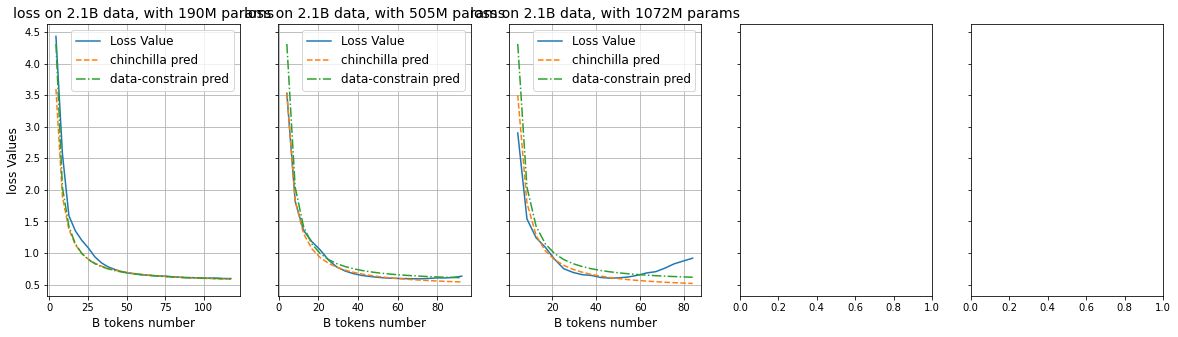

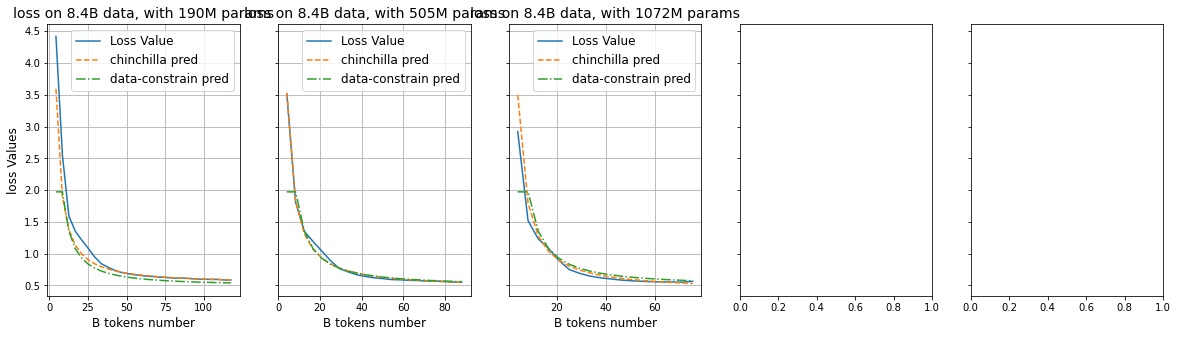

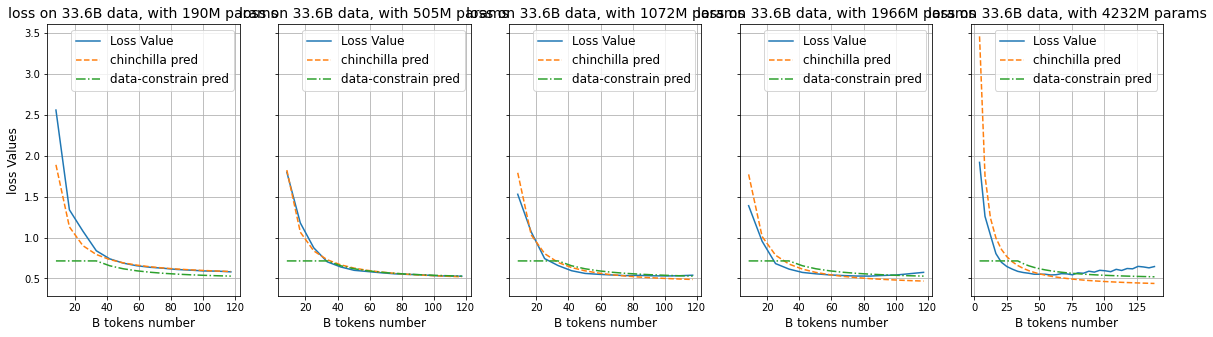

In [12]:

def plot_figures(rows, columns, entries, unique_tokens, ut):
    indices = [i for i, x in enumerate(unique_tokens) if x == ut]
    rows = [rows[i] for i in indices]
    columns = [columns[i] for i in indices]
    entries = [entries[i] for i in indices]
    ls_tmp = [ls[i] for i in indices]
    
    unique_rows = set(rows)
    unique_rows = sorted(unique_rows)
    fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

    for j, row in enumerate(unique_rows):
        indices = [i for i, x in enumerate(rows) if x == row]
        x_vals = [columns[i] for i in indices]
        y_vals = [entries[i] for i in indices]
        f_vals = [chinchilla_law(row,x, [7.003183, 2.798342, -1.0652758, 0.45787653, 1.1685705]) for x in x_vals]
        g_vals = [ls_tmp[i] for i in indices]

        axs[j].plot(x_vals, y_vals, label='Loss Value')
        axs[j].plot(x_vals, f_vals, label='chinchilla pred', linestyle='--')
        axs[j].plot(x_vals, g_vals, label='data-constrain pred', linestyle='-.')
        axs[j].set_title(f"loss on {ut:.1f}B data, with {row*1e-6:.0f}M params", fontsize=14)
        axs[j].set_xlabel('B tokens number', fontsize=12)
        axs[j].grid(True)
        if j == 0:
            axs[j].set_ylabel('loss Values', fontsize=12)
        axs[j].legend(fontsize=12)

# Plot the figures
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/16)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/4)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6)


# Symbolic Music Scaling (SMS) Law

## Continuous Adaptation of the Data-Constrained Law

To enhance the predictive accuracy of the Data-Constrained law for continuous domains, we extend the original discrete formulation of $D'$ to accommodate continuous variables, allowing for a more nuanced understanding of data constraints in varied contexts. 
\begin{equation}\label{eq-D''}
    L(N, D, U_D) = \frac{A}{N^\alpha} + \frac{B}{{D''}^\beta} + E
\end{equation}

where $k$ is a new parameter to be fit, and $D''$, the adjusted data size, is given by:
\begin{equation}
D''= \frac{1-k^{D/U_D}}{1-k}U_D.
\end{equation}

The definition of $D'$ in [6] is defined from a discrete version and can not be extended to the case when D is less than $U_D$. So we reform the Equation of $D'$ to
\begin{equation}
\begin{split}
    D'&=\frac{1-(1-\delta)^{\frac{D}{U_D}}}{\delta}\cdot U_D\\
    &=\frac{1-k_d^{\frac{D}{U_D}}}{1-k_d}\cdot U_D
\end{split}
\end{equation}
where $k_d:= 1-\delta$. This equation is equivalent to equation $D'$ when $D$ is a positive integer times $U_D$.

We implemented a formula symmetric to $N'$ with $U_N$ and $k_N$. But the calculation results of $k_N\approx 0.999$. To make the formula simple, we use the original $N$ instead of $N'$ in the following formula.

In [14]:
# direct scale up law, equivalent to eq 10
import torch
import numpy as np
from tqdm import tqdm
import math



def loss(inp, params, panelty=0):
    a, b, e, alpha, beta, k_d = params
    p, t, ut, l = inp[:, 0], inp[:, 1], inp[:, 2], inp[:, 3]
    pre_lse = torch.stack([
        a - alpha * torch.log(p ),
        b - beta * torch.log(ut * (1 - torch.pow(k_d, t/ut)) / (1-k_d) ),
        e.expand((inp.shape[0]))
    ])

    post_lse = torch.logsumexp(pre_lse, dim=0)
    huber_loss = torch.nn.functional.huber_loss(post_lse, torch.log(l), delta=1e-3, reduction='none')

    return huber_loss.sum() + panelty * torch.relu(k_d - 0.99) 

def minimize_loss(inp, init_params=[6, 6, 6, -1, 0.28, 0.32, 0.3], steps=50, fixed=False, fixed_except_b=False, panelty=0):
    params = torch.nn.Parameter(data=torch.Tensor(init_params))

    lbfgs = torch.optim.LBFGS([params],
                    lr=1e-1,
                    history_size=10,
                    max_iter=20,
                    line_search_fn="strong_wolfe")

    def closure():
        lbfgs.zero_grad()
        l = loss(inp, params, panelty=panelty)

        l.backward()
        if fixed:
            # Do not backprop on fixed params
            # https://discuss.pytorch.org/t/set-a-portion-of-a-tensor-to-have-requires-grad-false/157856
            params.grad[:5] = 0
        return l

    history_lbfgs = []
    for i in range(steps):
        l = lbfgs.step(closure)
    return l, params

assert len(tokens) == len(unique_tokens) == len(losses) == len(model_params)



inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(train_model_params, train_tokens, train_unique_tokens, train_losses)
])
inp.require_grad = True
min_loss = 1e10

a, b, e, alpha, beta = [7.003183, 2.798342, -1.0652758, 0.45787653, 1.1685705]
# for a in tqdm(np.linspace(0, 12, 4)):
#     for b in np.linspace(0, 12, 4):
#         for e in np.linspace(-1, 1, 4):
#             for alpha in np.linspace(0, 1, 4):
#                 for beta in np.linspace(0, 1, 4):
for k_d in np.linspace(0.05, 0,95, 4):
    l, params = minimize_loss(inp, [a, b, e, alpha, alpha, k_d], panelty=100)
    if l < min_loss:
        min_loss = l
        best_params = params.detach().numpy()
        print("Current loss: ", loss(inp, torch.nn.Parameter(data=torch.Tensor(best_params)), panelty=0))
        print("Current loss & params: ", min_loss, list(best_params))


print("Samples: ", len(inp))
print("Min Loss: ", min_loss)
print("a, b, e, alpha, beta: ", list(best_params))


Current loss:  tensor(0.0194, grad_fn=<AddBackward0>)
Current loss & params:  tensor(0.0194, grad_fn=<AddBackward0>) [6.9954867, 2.2420964, -0.66389364, 0.60971564, 1.0426325, 0.99]
Current loss:  tensor(0.0129, grad_fn=<AddBackward0>)
Current loss & params:  tensor(0.0129, grad_fn=<AddBackward0>) [7.002694, 2.44263, -0.98767847, 0.48584244, 1.0216428, 0.9899998]
Samples:  179
Min Loss:  tensor(0.0129, grad_fn=<AddBackward0>)
a, b, e, alpha, beta:  [7.002694, 2.44263, -0.98767847, 0.48584244, 1.0216428, 0.9899998]


In [15]:
# R2 score with improved data constrained law
import torch

# best_params = [7.002694, 2.44263, -0.98767847, 0.48584244, 1.0216428, 0.9899998]

def new_law(N, D, U, params):
    a, b, e, alpha, beta, k_d  = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    D_new = (1-k_d**(D/U))/(1-k_d)*U
    L = E + A/N**alpha + B / D_new**beta
    return L

from sklearn.metrics import r2_score

inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(test_model_params, test_tokens, test_unique_tokens, test_losses)
])
ls = new_law(inp[:,0], inp[:,1], inp[:,2], best_params)
print("r2_score:", r2_score(inp[:,-1], ls))
test_l = torch.nn.functional.huber_loss(torch.log(ls), torch.log(inp[:, -1]), delta=1e-3, reduction='none').sum()
print("test loss:", float(test_l))

inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(train_model_params, train_tokens, train_unique_tokens, train_losses)
])
ls = new_law(inp[:,0], inp[:,1], inp[:,2], best_params)
print("r2_score:", r2_score(inp[:,-1], ls))
test_l = torch.nn.functional.huber_loss(torch.log(ls), torch.log(inp[:, -1]), delta=1e-3, reduction='none').sum()
print("train loss:", float(test_l))


inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(model_params, tokens, unique_tokens, losses)
])
from sklearn.metrics import r2_score
ls = new_law(inp[:,0], inp[:,1], inp[:,2], best_params)
print(r2_score(inp[:,-1], ls))


r2_score: 0.31141599520770225
test loss: 0.007285280618816614
r2_score: 0.9074735030592717
train loss: 0.012917587533593178
0.8860252390131715


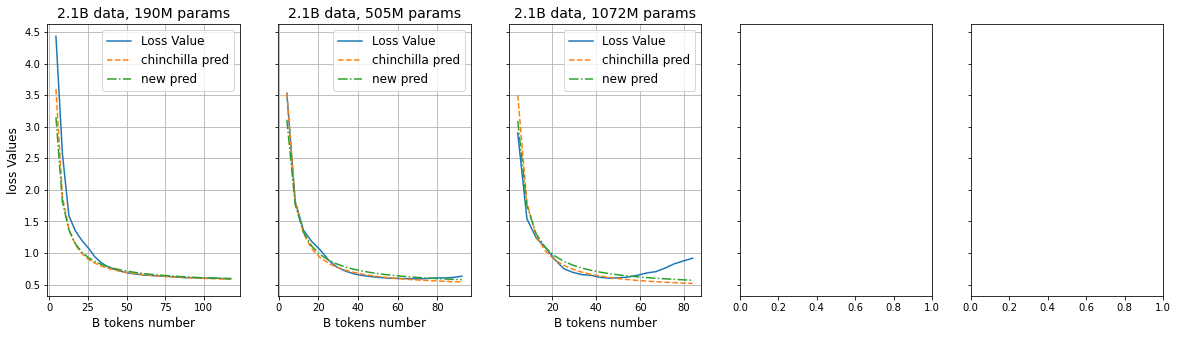

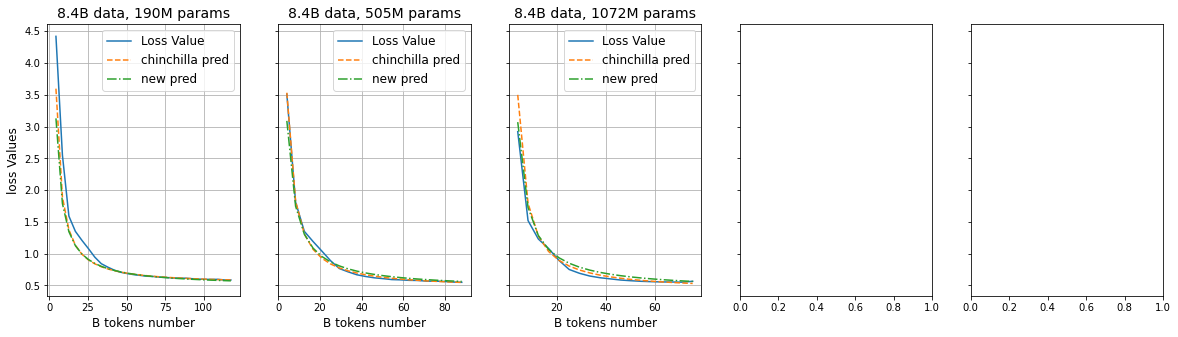

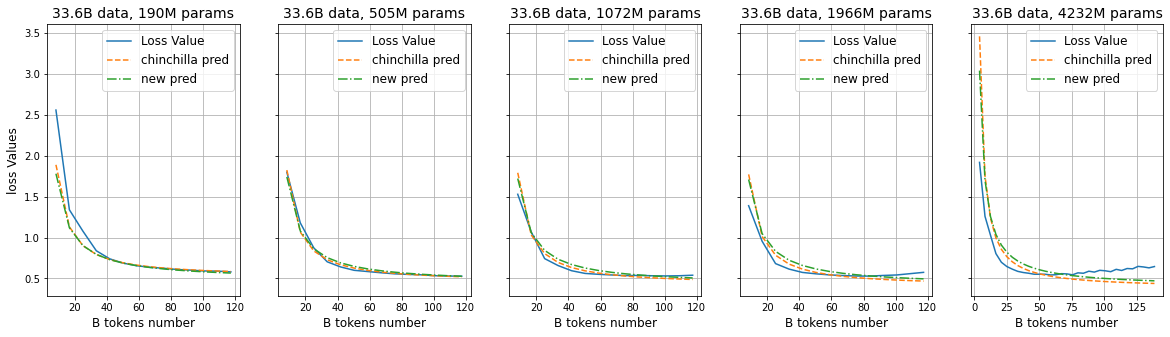

In [16]:
import matplotlib.pyplot as plt


def plot_figures(rows, columns, entries, unique_tokens, ut):
    indices = [i for i, x in enumerate(unique_tokens) if x == ut]
    rows = [rows[i] for i in indices]
    columns = [columns[i] for i in indices]
    entries = [entries[i] for i in indices]
    ls_tmp = [ls[i] for i in indices]
    
    unique_rows = set(rows)
    unique_rows = sorted(unique_rows)
    fig, axs = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

    for j, row in enumerate(unique_rows):
        indices = [i for i, x in enumerate(rows) if x == row]
        x_vals = [columns[i] for i in indices]
        y_vals = [entries[i] for i in indices]
        f_vals = [chinchilla_law(row,x,[7.003183, 2.798342, -1.0652758, 0.45787653, 1.1685705]) for x in x_vals]
        g_vals = [ls_tmp[i] for i in indices]

        axs[j].plot(x_vals, y_vals, label='Loss Value')
        axs[j].plot(x_vals, f_vals, label='chinchilla pred', linestyle='--')
        axs[j].plot(x_vals, g_vals, label='new pred', linestyle='-.')
        axs[j].set_title(f"{ut:.1f}B data, {row*1e-6:.0f}M params", fontsize=14)
        axs[j].set_xlabel('B tokens number', fontsize=12)
        axs[j].grid(True)
        if j == 0:
            axs[j].set_ylabel('loss Values', fontsize=12)
        axs[j].legend(fontsize=12)

# Plot the figures
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/16)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/4)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6)


## Incorporation of a New Term.
To address the model's limitations in accurately capturing performance metrics for smaller data sizes, we introduce an additional term, as delineated in following Equation. This modification aims to refine the model's fidelity, particularly in scenarios characterized by limited data availability.

\begin{equation}\label{eq-1/ND}
L(N, D, U_D) = \frac{d}{N^\alpha \cdot D''^\beta} + \frac{A}{N^\alpha} + \frac{B}{D''^\beta} + E.
\end{equation}

In [ ]:
#  more explanation on intuition
In our submission, we present an in-depth analysis of the model's loss dynamics as illustrated in previous figure, which juxtaposes the empirical loss trajectory (depicted through a blue line) against the theoretical predictions derived from the Chinchilla Law (illustrated by a yellow line) and further contextualized by Equation \ref{eq-D''}. This comparative study spans three distinct datasets—2.1B, 8.4B, and 33.6B data points—across models of varying capacities: 190M, 505M, and 1.07B parameters, respectively, arranged in a matrix of subfigures with datasets delineated by rows and model capacities by columns.

Observations across all data volumes reveal a nuanced interaction between model and data sizes: for smaller datasets and model sizes (190M parameters), predictions consistently underestimate actual loss values, whereas for smaller datasets paired with larger models (1.07B parameters), predictions tend to overestimate. This discrepancy underscores a critical insight: loss reduction accelerates with increasing model size, suggesting a modified loss function, $\frac{A+\epsilon}{N^\alpha}$ over the simpler $\frac{A}{N^\alpha}$

Crucially, the term $\epsilon$ emerges as a function of a single variable $N$, ensuring variability in $\frac{\epsilon}{N^\alpha}$ across each unique model configuration shifting upwards or downwards without changing the shape. The ideal adjustment implies that $\epsilon$ approaches zero for large datasets, yet remains significant for smaller ones, highlighting its dependency on data volume $D$.

In addressing potential overfitting, our strategy focuses on minimizing parameter growth in line with Equation \ref{eq-D''}. A straightforward approach involves augmenting the loss $L$ into a polynomial encompassing $\frac{A}{N^\alpha}$ and $\frac{B}{D^\beta}$, with Equation \ref{eq-1/ND} introducing an additional term, $\frac{d}{N^\alpha\cdot D^\beta}$, to the existing framework. This refinement, while ostensibly simple, has been shown to yield robust and promising outcomes, exemplifying the efficacy of our proposed modifications in enhancing model performance within the context of scaling laws.

In [18]:
# scale up law with norm
import torch
import numpy as np
from tqdm import tqdm
import math


def loss(inp, params, panelty=0):
    a, b, e, alpha, beta, k_d, d = params
    p, t, ut, l = inp[:, 0], inp[:, 1], inp[:, 2], inp[:, 3]
    pre_lse = torch.stack([
        a - alpha * torch.log(p),
        # b - beta * torch.log(ut) - beta * torch.log((1 - torch.pow(k_d, t/ut)) / (1-k_d)  - ep *(torch.pow(k_m, t/ut) -1) / (k_m - 1)),
        b - beta * torch.log(ut * (1 - torch.pow(k_d, t/ut)) / (1-k_d)),
        d -  alpha * torch.log(p) - beta * torch.log(ut * (1 - torch.pow(k_d, t/ut)) / (1-k_d)),
        e.expand((inp.shape[0]))
    ])

    post_lse = torch.logsumexp(pre_lse, dim=0)
    huber_loss = torch.nn.functional.huber_loss(post_lse, torch.log(l), delta=1e-3, reduction='none')

    return huber_loss.sum() + panelty * torch.relu(k_d - 0.99) 

def minimize_loss(inp, init_params=[6, 6, 6, -1, 0.28, 0.32, 0.3], steps=50, fixed=False, fixed_except_b=False, panelty=0):
    params = torch.nn.Parameter(data=torch.Tensor(init_params))

    lbfgs = torch.optim.LBFGS([params],
                    lr=1e-1,
                    history_size=10,
                    max_iter=20,
                    line_search_fn="strong_wolfe")

    def closure():
        lbfgs.zero_grad()
        l = loss(inp, params, panelty=panelty)

        l.backward()
        if fixed:
            # Do not backprop on fixed params
            # https://discuss.pytorch.org/t/set-a-portion-of-a-tensor-to-have-requires-grad-false/157856
            params.grad[:5] = 0
        return l

    history_lbfgs = []
    for i in range(steps):
        l = lbfgs.step(closure)
    return l, params

assert len(tokens) == len(unique_tokens) == len(losses) == len(model_params)


inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(train_model_params, train_tokens, train_unique_tokens, train_losses)
])
inp.require_grad = True
min_loss = 1e10

a, b, e, alpha, beta = [0.00012726308, 0.0012482455, -0.96883684, 0.28083795, 0.98476225]
# [0.00012726308, 0.0012482455, -0.96883684, 0.28083795, 0.98476225, 0.98999035, 0.03775, 2.1, 8.002226]
# for a in tqdm(np.linspace(0, 12, 4)):
#     for b in np.linspace(0, 12, 4):
#         for e in np.linspace(-1, 1, 4):
#             for alpha in np.linspace(0, 1, 4):
#                 for beta in np.linspace(0, 1, 4):
for d in np.linspace(0, 12, 4):
    for k_d in np.linspace(0.8, 0.95, 5):
        l, params = minimize_loss(inp, [a, b, e, alpha, beta, k_d, d], panelty=100)
        if l < min_loss:
            min_loss = l
            best_params = params.detach().numpy()
            print("Current loss: ", loss(inp, torch.nn.Parameter(data=torch.Tensor(best_params)), panelty=0))
            print("Current loss & params: ", min_loss, list(best_params))

print("Samples: ", len(inp))
print("Min Loss: ", min_loss)
print("a, b, e, alpha, beta: ", list(best_params))


Current loss:  tensor(0.0400, grad_fn=<AddBackward0>)
Current loss & params:  tensor(0.0400, grad_fn=<AddBackward0>) [0.00734502, 0.08727153, -0.67449665, 0.12163064, 0.79753464, 0.9899999, 0.0017289093]
Current loss:  tensor(0.0293, grad_fn=<AddBackward0>)
Current loss & params:  tensor(0.0293, grad_fn=<AddBackward0>) [0.008660912, 0.027199933, -0.74978286, 0.12630278, 0.88271487, 0.9899999, 3.999738]
Current loss:  tensor(0.0222, grad_fn=<AddBackward0>)
Current loss & params:  tensor(0.0222, grad_fn=<AddBackward0>) [0.003029555, 0.015649278, -0.85278404, 0.12733425, 0.93315893, 0.99, 4.0049486]
Current loss:  tensor(0.0219, grad_fn=<AddBackward0>)
Current loss & params:  tensor(0.0219, grad_fn=<AddBackward0>) [0.0016443419, 0.015396231, -0.8648922, 0.12644048, 0.93630034, 0.98999995, 4.0065026]
Current loss:  tensor(0.0106, grad_fn=<AddBackward0>)
Current loss & params:  tensor(0.0106, grad_fn=<AddBackward0>) [0.0002489997, 0.0032770555, -0.9258009, 0.28665793, 0.9717901, 0.9899967, 

In [23]:
# R2 score with norm
import torch

best_params = [0.00019876535, 0.0013778666, -0.9516954, 0.28226236, 0.98411983, 0.9899803, 7.9995966]

def new_law(N, D, U, params):
    a, b, e, alpha, beta, k_d, d  = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    d = np.exp(d)
#     UN = np.minimum(N,optimal_N(D_to_C(U)))
    D_new = (1-k_d**(D/U))/(1-k_d)*U
    L = d/((N)**alpha * D_new**beta) + E + A/(N)**alpha + B / D_new**beta
    return L


inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(test_model_params, test_tokens, test_unique_tokens, test_losses)
])
from sklearn.metrics import r2_score
ls = new_law(inp[:,0], inp[:,1], inp[:,2], best_params)
print("test r2_score:", r2_score(inp[:,-1], ls))
test_l = torch.nn.functional.huber_loss(torch.log(ls), torch.log(inp[:, -1]), delta=1e-3, reduction='none').sum()
print("test loss:", float(test_l))

inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(train_model_params, train_tokens, train_unique_tokens, train_losses)
])
ls = new_law(inp[:,0], inp[:,1], inp[:,2], best_params)
print("train r2_score:", r2_score(inp[:,-1], ls))
test_l = torch.nn.functional.huber_loss(torch.log(ls), torch.log(inp[:, -1]), delta=1e-3, reduction='none').sum()
print("train loss:", float(test_l))

inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(model_params, tokens, unique_tokens, losses)
])
ls = new_law(inp[:,0], inp[:,1], inp[:,2], best_params)
print(r2_score(inp[:,-1], ls[:]))


test r2_score: 0.8579525131750498
test loss: 0.006164026912301779
train r2_score: 0.975916244823858
train loss: 0.010234356857836246
0.9718027897582449


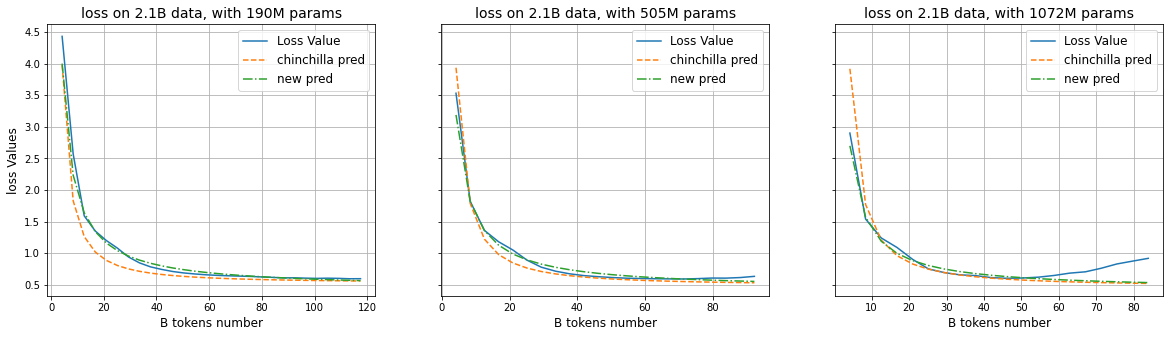

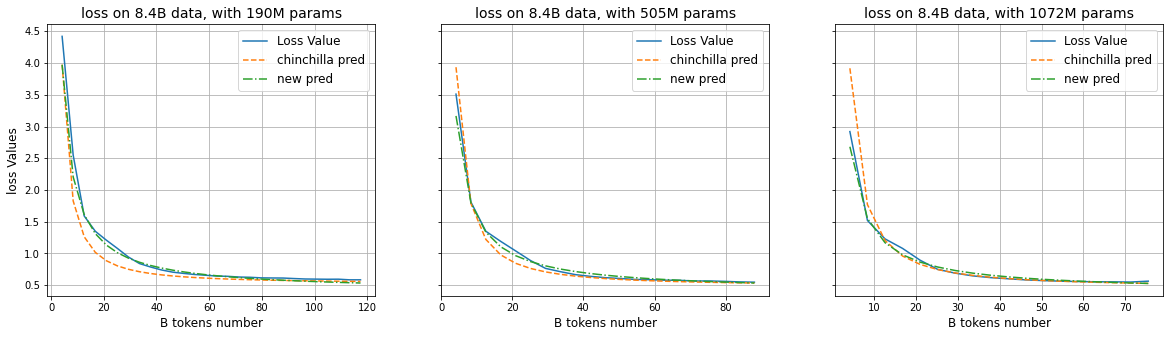

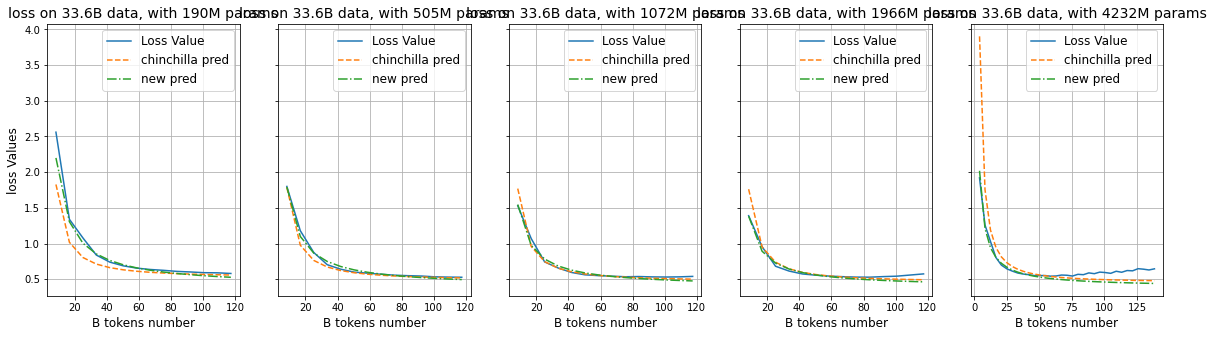

In [24]:

def plot_figures(rows, columns, entries, unique_tokens, ut):
    indices = [i for i, x in enumerate(unique_tokens) if x == ut]
    rows = [rows[i] for i in indices]
    columns = [columns[i] for i in indices]
    entries = [entries[i] for i in indices]
    ls_tmp = [ls[i] for i in indices]
    
    unique_rows = set(rows)
    unique_rows = sorted(unique_rows)
    fig, axs = plt.subplots(1, len(unique_rows), figsize=(20, 5), sharey=True)

    for j, row in enumerate(unique_rows):
        indices = [i for i, x in enumerate(rows) if x == row]
        x_vals = [columns[i] for i in indices]
        y_vals = [entries[i] for i in indices]
        f_vals = [chinchilla_law(row,x,[11.046319, 3.2550755,-0.8075609, 0.7107246,  1.4071795]) for x in x_vals]
        g_vals = [ls_tmp[i] for i in indices]

        axs[j].plot(x_vals, y_vals, label='Loss Value')
        axs[j].plot(x_vals, f_vals, label='chinchilla pred', linestyle='--')
        axs[j].plot(x_vals, g_vals, label='new pred', linestyle='-.')
        axs[j].set_title(f"loss on {ut:.1f}B data, with {row*1e-6:.0f}M params", fontsize=14)
        axs[j].set_xlabel('B tokens number', fontsize=12)
        axs[j].grid(True)
        if j == 0:
            axs[j].set_ylabel('loss Values', fontsize=12)
        axs[j].legend(fontsize=12)

# Plot the figures
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/16)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/4)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6)


## Modelling Overfitting Settings.
Previous iterations of the model fall short in predicting overfitting, particularly beyond early stopping thresholds. This gap is especially pronounced in the context of Data-Constrained environments, such as music, where open-source data is limited. To this end, we introduce a new component, $L_{overfit}$, to the model, encapsulated in following equation, to specifically account for overfitting losses:

\begin{equation}\label{eq-MuPT}
    L\left(N, D, U_D\right)=\frac{d}{N^\alpha\cdot D''^\beta} + \frac{A}{N^\alpha} + \frac{B}{D''^\beta} +E + L_{overfit}
\end{equation}
where 
\begin{equation} \label{eq-residule}
    L_{overfit} = GELU\left\{k_d\cdot D + k_n\cdot \log(N)-k_u\cdot \log(U_D) - k_{in}\right\}
\end{equation}

is our overfitting formulation. 


### plot of residules

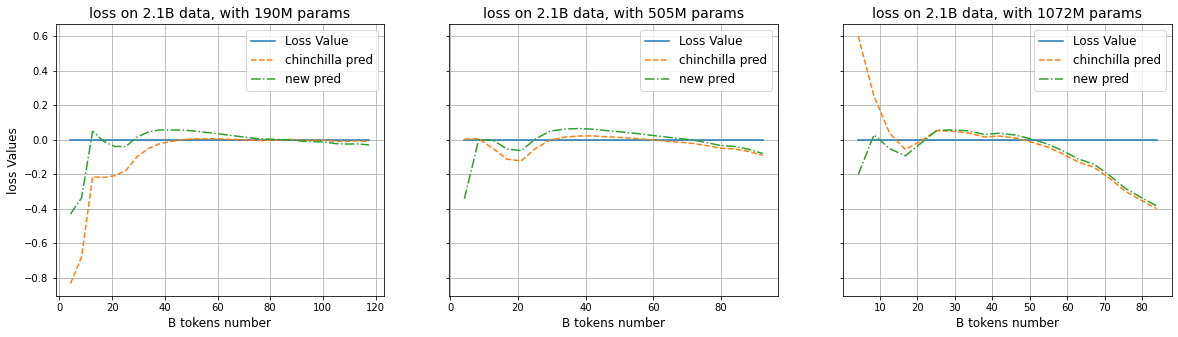

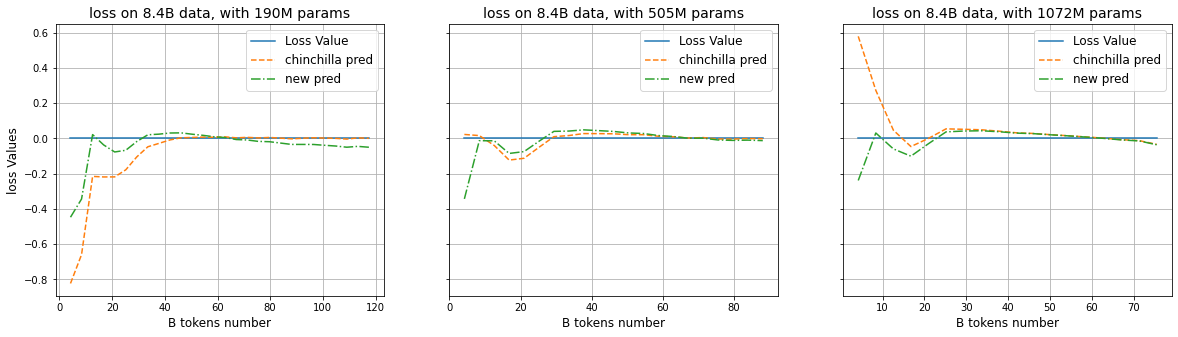

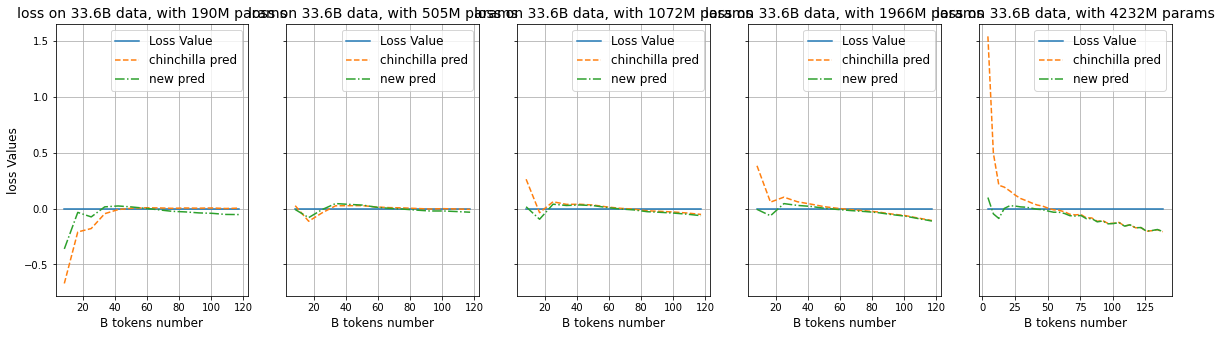

In [26]:
# plot of residules


def plot_figures(rows, columns, entries, unique_tokens, ut):
    indices = [i for i, x in enumerate(unique_tokens) if x == ut]
    rows = [rows[i] for i in indices]
    columns = [columns[i] for i in indices]
    entries = [entries[i] for i in indices]
    ls_tmp = [ls[i] for i in indices]
    
    unique_rows = set(rows)
    unique_rows = sorted(unique_rows)
    fig, axs = plt.subplots(1, len(unique_rows), figsize=(20, 5), sharey=True)

    for j, row in enumerate(unique_rows):
        indices = [i for i, x in enumerate(rows) if x == row]
        x_vals = np.array([columns[i] for i in indices])
        y_vals = np.array([entries[i] for i in indices])
        f_vals = np.array([chinchilla_law(row,x,
                                          [7.003183, 2.798342, -1.0652758, 0.45787653, 1.1685705]) 
                           for x in x_vals])
        g_vals = np.array([ls_tmp[i] for i in indices])

        axs[j].plot(x_vals, y_vals - y_vals, label='Loss Value')
        axs[j].plot(x_vals, f_vals - y_vals, label='chinchilla pred', linestyle='--')
        axs[j].plot(x_vals, g_vals - y_vals, label='new pred', linestyle='-.')
        axs[j].set_title(f"loss on {ut:.1f}B data, with {row*1e-6:.0f}M params", fontsize=14)
        axs[j].set_xlabel('B tokens number', fontsize=12)
        axs[j].grid(True)
        if j == 0:
            axs[j].set_ylabel('loss Values', fontsize=12)
        axs[j].legend(fontsize=12)

# Plot the figures
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/16)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6/4)
plot_figures(model_params, tokens, losses,  unique_tokens, 33.6)


### residule looks like linear after 40B training tokens

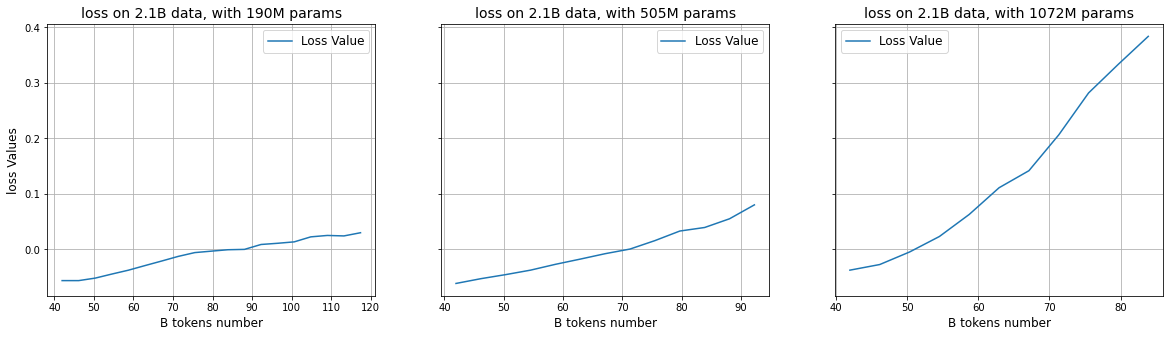

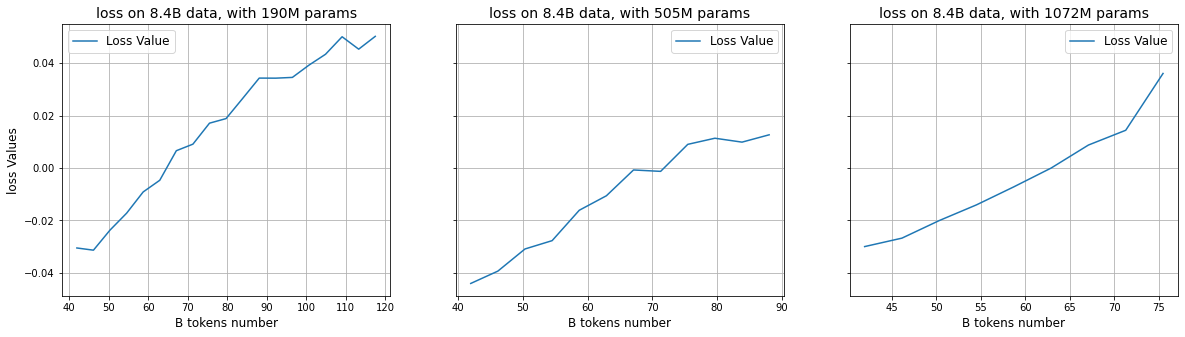

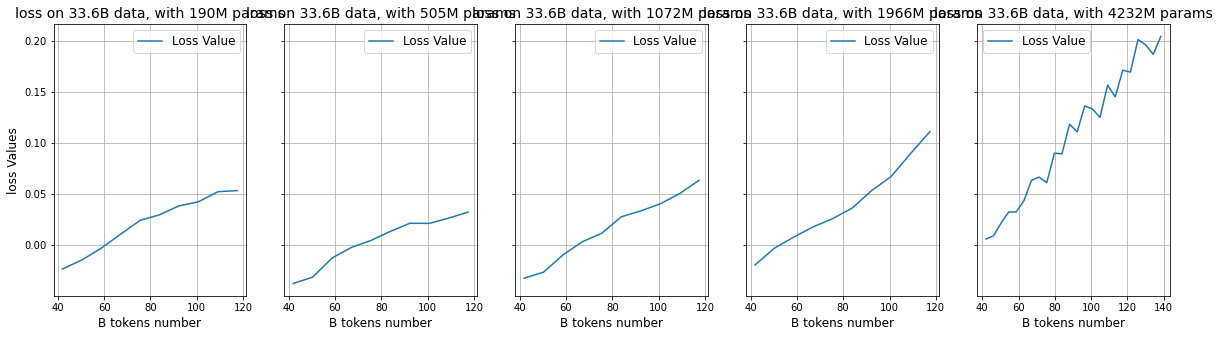

In [27]:
# residule looks like linear after 40B training tokens
import torch


inp = torch.Tensor([
    [p, t, ut, l] for p, t, ut, l in  ### UT instead of T as 2nd arg
    zip(model_params, tokens, unique_tokens, losses)
])
from sklearn.metrics import r2_score
ls = new_law(inp[:,0], inp[:,1], inp[:,2], best_params)
residule = torch.tensor(losses) - ls
indices = [i for i, x in enumerate(tokens) if x >39]
new_model_params = [model_params[i] for i in indices]
new_tokens = [tokens[i] for i in indices]
new_unique_tokens = [unique_tokens[i] for i in indices]
new_residule = [residule[i] for i in indices]


def plot_figures(rows, columns, entries, unique_tokens, ut):
    indices = [i for i, x in enumerate(unique_tokens) if x == ut]
    rows = [rows[i] for i in indices]
    columns = [columns[i] for i in indices]
    entries = [entries[i] for i in indices]
    ls_tmp = [ls[i] for i in indices]
    
    unique_rows = set(rows)
    unique_rows = sorted(unique_rows)
    fig, axs = plt.subplots(1, len(unique_rows), figsize=(20, 5), sharey=True)

    for j, row in enumerate(unique_rows):
        indices = [i for i, x in enumerate(rows) if x == row]
        x_vals = np.array([columns[i] for i in indices])
        y_vals = np.array([entries[i] for i in indices])
        f_vals = np.array([chinchilla_law(row,x,
                                          [11.046319, 3.2550755,-0.8075609, 0.7107246,  1.4071795]) 
                           for x in x_vals])
        g_vals = np.array([ls_tmp[i] for i in indices])

        axs[j].plot(x_vals, y_vals, label='Loss Value')
#         axs[j].plot(x_vals, f_vals - y_vals, label='chinchilla pred', linestyle='--')
#         axs[j].plot(x_vals, g_vals - y_vals, label='new pred', linestyle='-.')
        axs[j].set_title(f"loss on {ut:.1f}B data, with {row*1e-6:.0f}M params", fontsize=14)
        axs[j].set_xlabel('B tokens number', fontsize=12)
        axs[j].grid(True)
        if j == 0:
            axs[j].set_ylabel('loss Values', fontsize=12)
        axs[j].legend(fontsize=12)

# Plot the figures
plot_figures(new_model_params, new_tokens, new_residule,  new_unique_tokens, 33.6/16)
plot_figures(new_model_params, new_tokens, new_residule,  new_unique_tokens, 33.6/4)
plot_figures(new_model_params, new_tokens, new_residule,  new_unique_tokens, 33.6/1)


### fit with linear regression
The progression of model capacities—doubling across rows and quadrupling across columns—illuminates a systematic pattern, suggesting that the early stopping points and consequently, the predicted loss, might be effectively modeled through a linear regression involving dataset size $D$, the logarithm of model capacity  $\log(N)$, and and the logarithm of unique tokens per epoch $\log(U_D)$. This observation culminates in the proposition of a regularization term formulated as $k_d\cdot D + k_n\cdot \log(N)-k_u\cdot \log(U_D) - k_{in}$, aimed at encapsulating and mitigating the observed overfitting dynamics.


In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Applying logarithm to model parameters and unique tokens
log_model_params = np.log(new_model_params)
log_unique_tokens = np.log(new_unique_tokens)

# Preparing the independent variables (X) and the dependent variable (y)
X = np.column_stack((log_model_params, new_tokens, log_unique_tokens))
y = np.array(new_residule)


# Decomposing data into training and testing sets based on model size
train_indices = np.array(new_model_params) < 1.5e9
test_indices = np.array(new_model_params) >= 1.5e9

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

# Creating the Linear Regression model
model = LinearRegression()

# Fitting the model on the training set
model.fit(X_train, y_train)

# Predicting the y values for both training and testing sets
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)
y_hat = model.predict(X)

# Calculating R^2 value for the training and testing sets
r_squared_train = r2_score(y_train, y_hat_train)
r_squared_test = r2_score(y_test, y_hat_test)

# Printing the results
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2 value for training set:", r_squared_train)
print("R^2 value for testing set:", r_squared_test)


Coefficients: [ 0.03611289  0.00162963 -0.01292277]
Intercept: -0.7941223997681423
R^2 value for training set: 0.34037471600359515
R^2 value for testing set: 0.9044527919585071


### GELU activation function

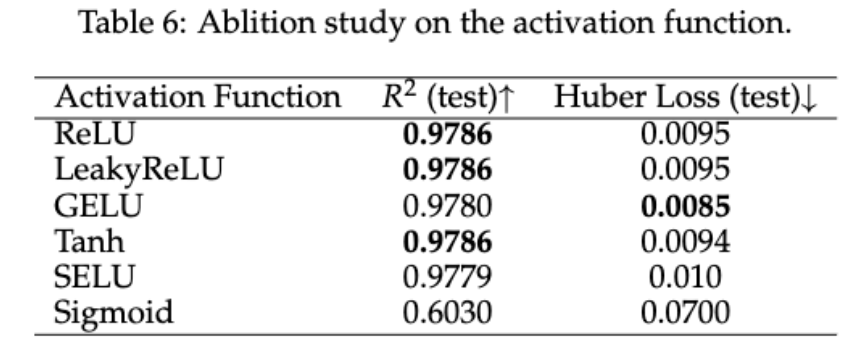

Empirical evidence, as detailed in our analysis, underscores the efficacy of applying the GELU function to the regularization term, notably achieving the lowest training loss alongside the second-highest $R^2$ value among the tested models. This finding is particularly salient given the broader magnitude of loss variations relative to $R^2$ values, thereby accentuating the GELU function's suitability for our regularization term. Consequently, the finalized model, incorporating the GELU-modulated regularization term, is depicted through a yellow line in Figure \ref{fig:residule}.

This strategic application of the GELU function not only mitigates the potential for excessive early training penalization but also optimizes the regularization term to enhance model performance effectively.% Such an approach underscores the importance of careful activation function selection in regularization, ensuring that model training is both efficient and theoretically sound, in alignment with the overarching goals of our research.


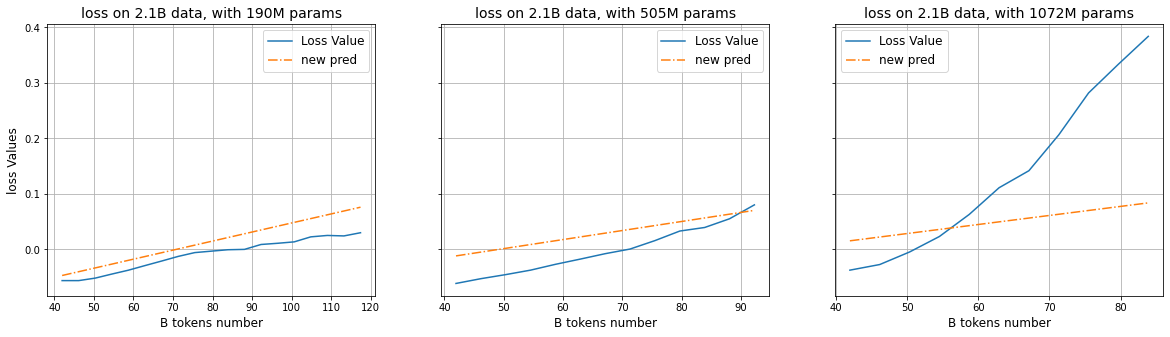

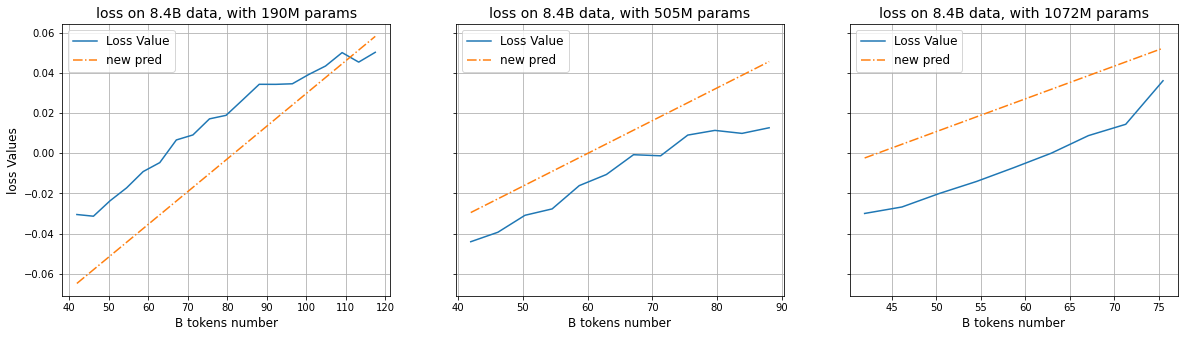

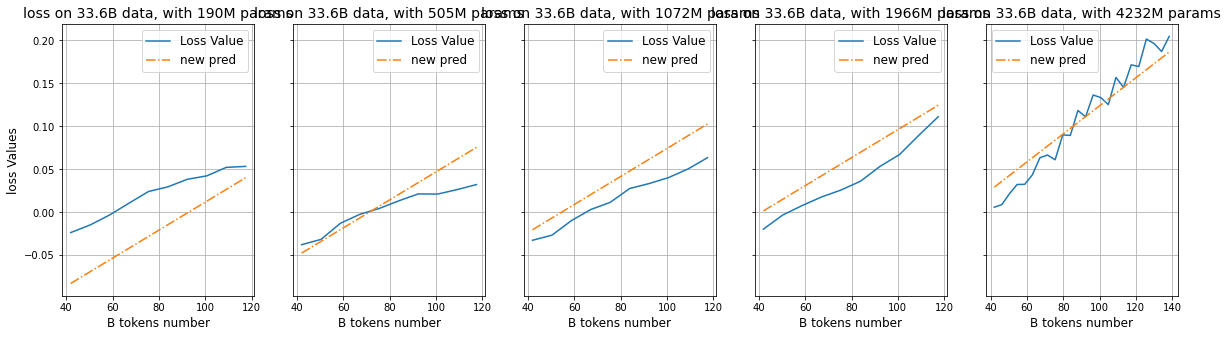

In [29]:

def plot_figures(rows, columns, entries, unique_tokens, ut):
    indices = [i for i, x in enumerate(unique_tokens) if x == ut]
    rows = [rows[i] for i in indices]
    columns = [columns[i] for i in indices]
    entries = [entries[i] for i in indices]
    # ls_tmp = [y_hat[i] for i in indices]
    ls_tmp = [y_hat[i] for i in indices]
    
    unique_rows = set(rows)
    unique_rows = sorted(unique_rows)
    fig, axs = plt.subplots(1, len(unique_rows), figsize=(20, 5), sharey=True)

    for j, row in enumerate(unique_rows):
        indices = [i for i, x in enumerate(rows) if x == row]
        x_vals = np.array([columns[i] for i in indices])
        y_vals = np.array([entries[i] for i in indices])
#         f_vals = np.array([chinchilla_law(row,x,
#                                           [11.046319, 3.2550755,-0.8075609, 0.7107246,  1.4071795]) 
#                            for x in x_vals])
        g_vals = np.array([ls_tmp[i] for i in indices])

        axs[j].plot(x_vals, y_vals, label='Loss Value')
#         axs[j].plot(x_vals, f_vals - y_vals, label='chinchilla pred', linestyle='--')
        axs[j].plot(x_vals, g_vals, label='new pred', linestyle='-.')
        axs[j].set_title(f"loss on {ut:.1f}B data, with {row*1e-6:.0f}M params", fontsize=14)
        axs[j].set_xlabel('B tokens number', fontsize=12)
        axs[j].grid(True)
        if j == 0:
            axs[j].set_ylabel('loss Values', fontsize=12)
        axs[j].legend(fontsize=12)

# Plot the figures
plot_figures(new_model_params, new_tokens, new_residule,  new_unique_tokens, 33.6/16)
plot_figures(new_model_params, new_tokens, new_residule,  new_unique_tokens, 33.6/4)
plot_figures(new_model_params, new_tokens, new_residule,  new_unique_tokens, 33.6/1)


## Parameter Fitting and Model Integration.

Initial parameter fitting for $\{\alpha$, $\beta$, $A$, $B$, $E\}$, and $d$, subsequent linear regression analysis, focusing on the residuals between $L$ and empirical observations, facilitates the calibration of overfitting parameters $\{k_d$, $k_n$, $k_u$, $k_{in}\}$ within Equation $L_{overfit}$. The integration of these components in SMS law not only predicts performance under constrained conditions but accounts for overfitting dynamics, helping to predict the true minimum of loss curve.


# experiment result
We use the $R^2$ value and Huber loss (with the parameter $\delta=1e-3$) between the authentic valid loss and predicted valid loss on small models (190M, 505M, 1.07B) to acquire the best scaling law. Then we use the best law to train two large models (with 1.97B and 4.23B). 

We optimized the SMS Law using the L-BFGS algorithm, the same with Chinchilla and Data-Constrained Laws. 

## SMS Law are the Best on the Training Set

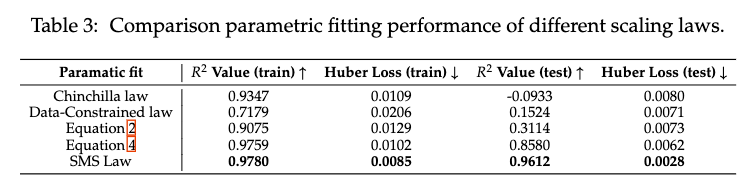

The integration of an additional term as delineated in Equation \ref{eq-1/ND}, alongside the introduction of a GELU regularization component in Equation \ref{eq-residule}, collectively underpins the superior performance of the SMS Law, as empirically evidenced by its training set outcomes. This is particularly notable in the context of our parametric fitting performance comparison (see Table \ref{table:Comparison}), where the SMS Law outshines other scaling laws, achieving the highest $R^2$ value (0.9780) and the lowest Huber loss (0.0085) on the training set. 

Although Equation 2 in section 4.1 does not eclipse the Chinchilla Law in performance metrics, it nonetheless presents a significant improvement over the Data-Constrained Law's $D'$ by leveraging $D''$, which is indicative of a refined approach to managing the constraints posed by data repetition. This nuanced handling of data repetition, inherent to Equation 2, suggests an enhanced generalization capability in such scenarios. Therefore, we culminate it along with other modifications, manifest in the SMS Law in order to enhance model performance and generalization at the same time. In fact, it indeed provides much better results in the test set.


## Scaled-up Performance Followed SMS Law
### prediction of SMS lows

In our SMS Law experimentation under a computational budget of $2\times10^{20}$ FLOPs, we initially aim to train a 2.10B (or 1.98B) parameter model across 2.82 epochs on the whole 33.6B dataset per epoch, achieving a loss of 0.5279 (or 0.5280). Engineering constraints necessitated a slight scale-down to a 1.97 billion parameter model, which, intriguingly, showed a minimal loss increase to 0.529 around 2.5 epochs. 

In [30]:
#  predict the best configuration of scaled-up model under 2e20 flops

best_params = [0.00019876535, 0.0013778666, -0.9516954, 0.28226236, 
               0.98411983, 0.9899803, 7.9995966]

def new_residule_law(N, D, U, params):
    a, b, e, alpha, beta, k_d, d  = params
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    d = np.exp(d)
    D_new = (1-k_d**(D/U))/(1-k_d)*U
    L = d/(N**alpha * D_new**beta) + E + A/N**alpha + B / D_new**beta
    L += torch.nn.GELU()(torch.tensor(model.coef_[0]*np.log(N) + 
                                 model.coef_[1]*D + model.coef_[2]*np.log(U) + model.intercept_) 
                    )
    return L

min_l = float("inf")
for i in range(10, 131):
    N = 0.1e9 * i
    for j in range(336,3360):
        if i * j > 20000: #148 * 336:
            continue
        D = .1*j
        U = min(33.6, D)
        new_l = new_residule_law(N, D, 33.6, best_params)
        if new_l < min_l:
            min_l, min_t, min_s = new_l, D, N        


print(f"Optimal configuration: {min_t:.2f}B tokens, {min_t/33.6:.2f} epochs, {min_s/1e6:.2f}M parameters")
print(min_l)
# Optimal configuration: 94.80B tokens, 2.82 epochs, 2100.00M parameters
# tensor(0.5279, dtype=torch.float64)
# Optimal configuration: 94.90B tokens, 2.82 epochs, 1980.00M parameters
# tensor(0.5280, dtype=torch.float64)

Optimal configuration: 94.80B tokens, 2.82 epochs, 2100.00M parameters
tensor(0.5279, dtype=torch.float64)


### prediction of Chinchilla Laws
Contrary to the predictions of SMS Law, the Chinchilla Law suggests optimal performance for a 990M parameter model over 6.1 epochs. Pushing boundaries, we continuously train the 1.07B parameter model and observe overfitting returns beyond 3 epochs, validating the SMS Law's advantages in this context.


In [31]:
# find the best configuration

best_params = [7.003183, 2.798342, -1.0652758, 0.45787653, 1.1685705]

def chinchilla_law(N, D, params):
    a, b, e, alpha = params[:4]
    beta = params[-1]
    A = np.exp(a)
    B = np.exp(b)
    E = np.exp(e)
    L = E + A/(N)**alpha + B / D**beta
    return L


def optimal_chinchinca(N_BASE, D_BASE, U_BASE):
    min_l = float("inf")
    for i in np.linspace(1, 20, 1000):
        D =  D_BASE*i
        U = min(U_BASE, D)
        N = N_BASE/i
        new_l = chinchilla_law(N, D,best_params)
        if new_l < min_l:
            min_l, min_t, min_s = new_l, D, N
        D =  D_BASE/i
        U = min(U_BASE, D)
        N = N_BASE*i
        new_l = chinchilla_law(N, D, best_params)
        if new_l < min_l:
            min_l, min_t, min_s = new_l, D, N
    return min_l, min_t, min_s

_, min_t, min_s = optimal_chinchinca(4e9, 50, 33.6)
print(f"Optimal chinchilla configuration: {min_t:.1f}B tokens, {min_t/33.6:.1f} epochs, {min_s/1e6:.1f}M parameters")
print(_)
# Optimal chinchilla configuration: 204.2B tokens, 6.1 epochs, 987.2M parameters
# 0.4612031745929319
chinchilla_law(1.072e9, 204.2, best_params)

Optimal chinchilla configuration: 204.1B tokens, 6.1 epochs, 980.1M parameters
0.4615092620533524


0.45810358554326175